# Audio Visual Reaction Time Simulation
This notebook use the decision making model by Wang and colleagues to simulate audio-visual reaction time task.


In [1]:
from platform import python_version

print(python_version())

3.8.8


## Material and Methods
### The two-variable network model

### Calling Library Fuctions

In [2]:
# LIBRARY

import numpy as np # vector manipulation
import math  # math functions
import sys
import pandas as pd
from scipy.stats import ttest_ind
# THIS IS FOR PLOTTING
%matplotlib inline
import matplotlib.pyplot as plt # side-stepping mpl backend
import warnings
warnings.filterwarnings("ignore")


### The Reduced Network Model

In [3]:
def H(x):
    a=270 # Hz/nA
    b=108 # Hz
    d=.154 # seconds
    f=(a*x-b)/(1-np.exp(-d*(a*x-b)))
    return f
x=np.arange(-1,1,0.01)


### Neural Circuit
$$ x_{1}=J_{11}S_1-J_{12}S_2+J_{13}S_3-J_{14}S_4+I_{0}+I_{1}+I_{noise,1}$$
$$ x_{2}=J_{22}S_2-J_{21}S_1+I_{0}+I_{2}+I_{noise,1}$$

where the synaptic couplings are $J_{11}=0.2609$, $J_{22}=0.2609$, $J_{12}=0.0497$ and $J_{21}=0.0497$.
$I_{0}=0.3255 nA$ represents external input 


In [4]:
def total_synaptic_current(S_1,S_2,S_3,S_4,I_1,I_2,I_noise_1,I_noise_2):
    # Synaptic coupling
    J_11=0.2609 # nA
    J_22=0.2609 # nA
    J_13=0*0.000497/np.sqrt(2) # nA
    J_24=0*0.000497/np.sqrt(2) # nA
  
    J_12=0.0497 # nA
    J_21=0.0497 # nA
    I_0=0.3255  # nA
    x_1=J_11*S_1-J_12*S_2+J_13*S_3+I_0+I_1+I_noise_1
    x_2=J_22*S_2-J_21*S_1+J_24*S_4+I_0+I_2+I_noise_2
    return x_1, x_2


### Background activity
$$ \tau_{AMPA}\frac{d I_{noise,i}(t)}{dt} =-I_{noise,i}(t)+\eta_i(t)\sqrt{\tau_{AMPA}}\sigma_{noise}$$

In [5]:
def Background_Activity(I_noise):
    h=0.1
    sigma_noise=0.02 # nA
    tau_AMPA=2 #ms
    eta_noise=np.random.normal(0,1,1)
    k=0#(-(I_noise)+eta_noise*np.sqrt(tau_AMPA)*sigma_noise)
    I_noise_new=I_noise+h/tau_AMPA*(-(I_noise+h/2*k)+eta_noise
                                *np.sqrt(tau_AMPA)*sigma_noise)
    return I_noise_new

### Network Dynamics
$$ \frac{d S_{i}}{dt} =-\frac{S_{i}}{\tau_S}+(1-S_{i})\gamma H_{i}$$

In [6]:
def Network_Dynamics_VIS(S,x):
    h=0.1/1000 #ms
    gamma=0.641
    tau_S=.100 #s
    k=(-S/tau_S+(1-S)*gamma*H(x)/1)
    S_new=S+h*(-(S+h/2*k)/tau_S+(1-S+h/2*k)*gamma*H(x))
    return S_new

def Network_Dynamics_AUDIO(S,x):
    h=0.1/1000 #ms
    gamma=0.641
    #tau_S=.10 #s
    tau_S=.100 #s
    k=(-S/tau_S+(1-S)*gamma*H(x)/1)
    S_new=S+h*(-(S+h/2*k)/tau_S+(1-S+h/2*k)*gamma*H(x))
    return S_new

### Input Current Target

$$ I_i=J_{A,ext}\mu_0\left(1+ \frac{c'}{100} \right) $$


In [7]:
def I_input_1(c_dash):
    J_A_ext=5.2/10000 # nA/Hz
    mu_0=30 # Hz
    I_motion=J_A_ext*mu_0*(1+(c_dash)/100)
    return I_motion

$$ I_2=J_{A,ext}\mu_0\left(1- \frac{c'}{100} \right) $$

In [8]:
def I_input_2(c_dash):
    J_A_ext=0.00052 # nA/Hz
    mu_0=30 # Hz
    I_motion=J_A_ext*mu_0*(1-(c_dash)/100)
    return I_motion

In [9]:
        
def Reaction_Time_MULT(Firing_Rate_1,Firing_Rate_2,Firing_Rate_3,Firing_Rate_4,Threshold,time):
    ANSWER=0
    RT=0
    count=0
    if (Firing_Rate_1>=Threshold )| (Firing_Rate_3 >=Threshold): 
        ANSWER=1
        RT=time
        count=1
    elif (Firing_Rate_2>=Threshold)|(Firing_Rate_4 >=Threshold):
        ANSWER=0
        #RT=time
        count=1
    return ANSWER,RT,count

In [10]:
def Reaction_Time_UNI(Firing_Rate_1,Firing_Rate_2,Threshold,time):
    ANSWER=0
    RT=0
    count=0
    if (Firing_Rate_1>=Threshold ): 
        ANSWER=1
        RT=time
        count=1
    elif (Firing_Rate_2>=Threshold):
        ANSWER=0
        RT=time
        count=1
    return ANSWER,RT,count

In [11]:
h=0.1
time=np.arange(-100,1500,h)
J_A_ext=0.00052 # nA/Hz
mu_0=30 # Hz
STIMULUS=[10.0]#,7.5,10.0,15.0]


Threshold=20
N=100


ALL_F_1=0.2*np.ones((N,len(time)))
ALL_F_2=0.2*np.ones((N,len(time)))
I_VIS_EXCITE=0.0*np.ones(len(time)) # np.zeros((1,len(time)))
I_VIS_INHIB=0.0*np.ones(len(time)) # np.zeros((1,len(time)))
I_AUDIO_EXCITE=0.0*np.ones(len(time)) # np.zeros((1,len(time)))
I_AUDIO_INHIB=0.0*np.ones(len(time)) # np.zeros((1,len(time)))

Firing_target_VIS_EXCITE=0*time # np.zeros((1,len(time)))
Firing_target_VIS_INHIB=0*time # np.zeros((1,len(time)))
Firing_target_AUDIO_EXCITE=0*time # np.zeros((1,len(time)))
Firing_target_AUDIO_INHIB=0*time # np.zeros((1,len(time)))

In [12]:
RT_AUDIO_coh_hit=[]
RT_AUDIO_coh_miss=[]#np.zeros(len(Vector_coherence))
Prob_AUDIO=[]#np.zeros(len(Vector_coherence))
RT_VIS_coh_hit=[]#np.zeros(len(Vector_coherence))
RT_VIS_coh_miss=[]#np.zeros(len(Vector_coherence))
Prob_VIS=[]#np.zeros(len(Vector_coherence))



j=0
for k in range(0,1):
  
    ANSWER_VIS=np.zeros(N)
    RT_VIS=np.zeros(N)
    RT_VIS=np.empty(N)
    RT_VIS[:] = np.NaN



    ANSWER_AUDIO=np.zeros(N)
    RT_AUDIO=np.zeros(N)
    ANSWER_AV=np.zeros(N)
    RT_AV=np.zeros(N)



    for n in range(0,N):
        if n%50==0:
            print(' n: %d' %(n))
        I_noise_VIS_EXCITE=0.001*np.random.normal(0,1,len(time))
        I_noise_VIS_INHIB=0.001*np.random.normal(0,1,len(time))

        I_noise_AUDIO_EXCITE=0.001*np.random.normal(0,1,len(time))
        I_noise_AUDIO_INHIB=0.001*np.random.normal(0,1,len(time))


        x_VIS_EXCITE=J_A_ext*mu_0*np.random.uniform(0,1,len(time))
        x_VIS_INHIB=J_A_ext*mu_0*np.random.uniform(0,1,len(time))
        x_AUDIO_EXCITE=J_A_ext*mu_0*np.random.uniform(0,1,len(time))
        x_AUDIO_INHIB=J_A_ext*mu_0*np.random.uniform(0,1,len(time))


        S_VIS_EXCITE=0.2*np.ones(len(time))+0.01*np.random.normal(0,1,len(time))
        S_VIS_INHIB=0.2*np.ones(len(time))+0.01*np.random.normal(0,1,len(time)) 
        S_AUDIO_EXCITE=0.2*np.ones(len(time))+0.01*np.random.normal(0,1,len(time))
        S_AUDIO_INHIB=0.2*np.ones(len(time))+0.01*np.random.normal(0,1,len(time)) 


 

        Firing_target_VIS_EXCITE[0]=H(x_VIS_EXCITE[0])
        Firing_target_VIS_INHIB[0]=H(x_VIS_INHIB[0])
        Firing_target_AUDIO_EXCITE[0]=H(x_VIS_EXCITE[0])
        Firing_target_AUDIO_INHIB[0]=H(x_VIS_INHIB[0])

        x_VIS_EXCITE,x_VIS_INHIB=total_synaptic_current(S_VIS_EXCITE,S_VIS_INHIB,
                                                                      S_AUDIO_EXCITE,S_AUDIO_INHIB,
                                                                      I_VIS_EXCITE,I_VIS_INHIB,
                                                                      I_noise_VIS_EXCITE,
                                                                      I_noise_VIS_INHIB)
        x_AUDIO_EXCITE,x_AUDIO_INHIB=total_synaptic_current(S_AUDIO_EXCITE,
                                                                          S_AUDIO_INHIB,
                                                                          S_VIS_EXCITE,
                                                                          S_VIS_INHIB,
                                                                          I_AUDIO_EXCITE,
                                                                          I_AUDIO_INHIB,
                                                                          I_noise_AUDIO_EXCITE,
                                                                          I_noise_AUDIO_INHIB)

        count_AUDIO=0

        count_VIS=0
        count_AV=0
        for i in range (0,len(time)-1):
            if time[i] >=0 and time[i]<1000:
                c_dash=STIMULUS[0]
            else:
                c_dash=0.0

        
            I_noise_VIS_EXCITE[i+1]=Background_Activity(I_noise_VIS_EXCITE[i])
            I_noise_VIS_INHIB[i+1]=Background_Activity(I_noise_VIS_INHIB[i])
            I_VIS_EXCITE[i+1]=I_input_1(c_dash) # AUDITORY INPUT
            I_VIS_INHIB[i+1]=I_input_1(-c_dash) # VISUAL INPUT
         
         
            S_VIS_EXCITE[i+1]=Network_Dynamics_VIS(S_VIS_EXCITE[i],x_VIS_EXCITE[i])
            S_VIS_INHIB[i+1]=Network_Dynamics_VIS(S_VIS_INHIB[i],x_VIS_INHIB[i])
            
            
            
            x_VIS_EXCITE[i+1],x_VIS_INHIB[i+1]=total_synaptic_current(S_VIS_EXCITE[i+1],S_VIS_INHIB[i+1],
                                                                      S_AUDIO_EXCITE[i+1],S_AUDIO_INHIB[i+1],
                                                                      I_VIS_EXCITE[i+1],I_VIS_INHIB[i+1],
                                                                      I_noise_VIS_EXCITE[i+1],
                                                                      I_noise_VIS_INHIB[i+1])
            
            I_noise_AUDIO_EXCITE[i+1]=Background_Activity(I_noise_AUDIO_EXCITE[i])
            I_noise_AUDIO_INHIB[i+1]=Background_Activity(I_noise_AUDIO_INHIB[i])
            
            I_AUDIO_EXCITE[i+1]=I_input_1(c_dash) # AUDITORY INPUT
            I_AUDIO_INHIB[i+1]=I_input_1(-c_dash) # VISUAL INPUT
      
            
            
            S_AUDIO_EXCITE[i+1]=Network_Dynamics_AUDIO(S_AUDIO_EXCITE[i],x_AUDIO_EXCITE[i])
            S_AUDIO_INHIB[i+1]=Network_Dynamics_AUDIO(S_AUDIO_INHIB[i],x_AUDIO_INHIB[i])
            
            x_AUDIO_EXCITE[i+1],x_AUDIO_INHIB[i+1]=total_synaptic_current(S_AUDIO_EXCITE[i+1],
                                                                          S_AUDIO_INHIB[i+1],
                                                                          S_VIS_EXCITE[i+1],
                                                                          S_VIS_INHIB[i+1],
                                                                          I_AUDIO_EXCITE[i+1],
                                                                          I_AUDIO_INHIB[i+1],
                                                                          I_noise_AUDIO_EXCITE[i+1],
                                                                          I_noise_AUDIO_INHIB[i+1])
            
            
            Firing_target_AUDIO_EXCITE[i+1]=H(x_AUDIO_EXCITE[i+1])
            Firing_target_AUDIO_INHIB[i+1]=H(x_AUDIO_INHIB[i+1])
            Firing_target_VIS_EXCITE[i+1]=H(x_VIS_EXCITE[i+1])
            Firing_target_VIS_INHIB[i+1]=H(x_VIS_INHIB[i+1])
           
            # AV RACE MODEL REACTION TIME
            if count_AV <0.5:
                ANSWER_AV[n],RT_AV[n],count_AV=Reaction_Time_MULT(Firing_target_VIS_EXCITE[i],Firing_target_VIS_INHIB[i],Firing_target_AUDIO_EXCITE[i],Firing_target_AUDIO_INHIB[i],Threshold,time[i])
            
            # VISUAL REACTION TIME THRESHOLD
            if count_VIS <0.5:
                ANSWER_VIS[n],RT_VIS[n],count_VIS=Reaction_Time_UNI(Firing_target_VIS_EXCITE[i],Firing_target_VIS_INHIB[i],Threshold,time[i])
            
            # AUDITORY REACTION TIME THRESHOLD
            if count_AUDIO <0.5:
                ANSWER_AUDIO[n],RT_AUDIO[n],count_AUDIO=Reaction_Time_UNI(Firing_target_AUDIO_EXCITE[i],Firing_target_AUDIO_INHIB[i],Threshold,time[i])

 n: 0
 n: 50


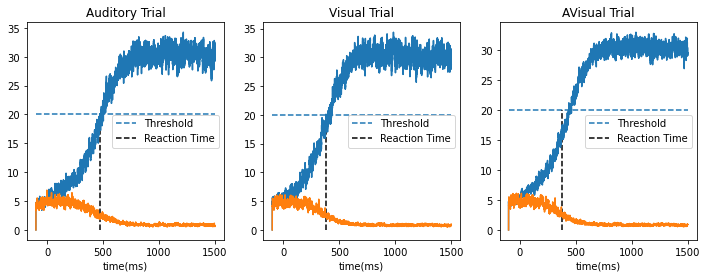

In [13]:
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(time,Firing_target_AUDIO_EXCITE.T)
plt.plot(time,Firing_target_AUDIO_INHIB.T)

plt.hlines(Threshold,-100,1500,linestyles='dashed',label='Threshold')
plt.vlines(RT_AUDIO[-1],0,Threshold,colors='k',linestyles='dashed',label='Reaction Time')
plt.xlabel('time(ms)')


plt.title("Auditory Trial")
plt.legend()
plt.subplot(132)
plt.plot(time,Firing_target_VIS_EXCITE.T)
plt.plot(time,Firing_target_VIS_INHIB.T)
plt.hlines(Threshold,-100,1500,linestyles='dashed',label='Threshold')
plt.vlines(RT_VIS[-1],0,Threshold,colors='k',linestyles='dashed',label='Reaction Time')
plt.legend()
plt.xlabel('time(ms)')
plt.title("Visual Trial")
plt.subplot(133)
plt.plot(time,(Firing_target_VIS_EXCITE.T+Firing_target_AUDIO_EXCITE.T)/2)
plt.plot(time,Firing_target_VIS_INHIB.T)
plt.hlines(Threshold,-100,1500,linestyles='dashed',label='Threshold')
plt.vlines(RT_AV[-1],0,Threshold,colors='k',linestyles='dashed',label='Reaction Time')
plt.legend()
plt.xlabel('time(ms)')
plt.title("AVisual Trial")
plt.show()

### Plotting
#### Input

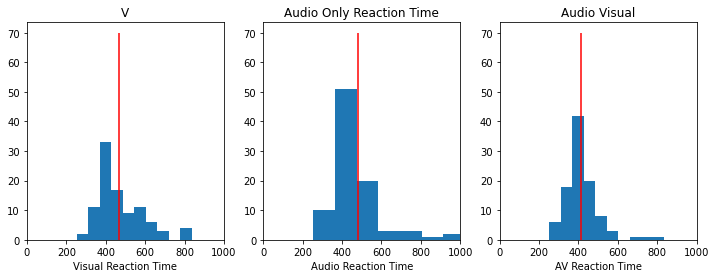

In [14]:
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hist(RT_VIS[ANSWER_VIS==1])
plt.vlines(np.mean(RT_VIS[ANSWER_VIS==1]),0,70,color='red')
plt.xlim(0,1000)

plt.xlabel('Visual Reaction Time')
plt.title('V')


plt.subplot(132)
plt.hist(RT_AUDIO[ANSWER_AUDIO==1])
plt.xlabel('Audio Reaction Time')
plt.vlines(np.mean(RT_AUDIO[ANSWER_AUDIO==1]),0,70,color='red')
plt.xlim(0,1000)



plt.title('Audio Only Reaction Time')

plt.subplot(133)
plt.hist(RT_AV[ANSWER_AV==1])
plt.vlines(np.mean(RT_AV[ANSWER_AV==1]),0,70,color='red',label="Mean Reaction Time")
plt.xlabel('AV Reaction Time')
plt.title('Audio Visual')
plt.xlim(0,1000)
plt.show()


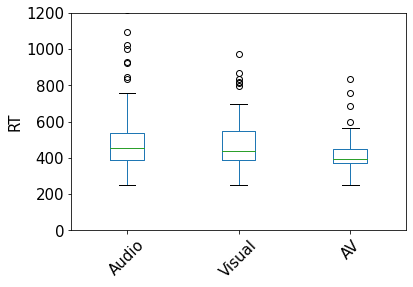

Ttest_indResult(statistic=3.981857844849004, pvalue=9.598243872321207e-05)

In [15]:
df=pd.DataFrame({'Audio': RT_AUDIO, 'Visual': RT_VIS,'AV':RT_AV})
#from matplotlib import pyplot as plt

fig = plt.figure(figsize=(6,4))
ax=df.boxplot(grid=False, rot=45, fontsize=15)
#fig.set_ylabel('RT')
ax.set_ylabel('RT', fontsize=15)
ax.set_ylim((0,1200))
#df.boxplot(grid=False, rot=45, fontsize=15)
plt.show()


ttest_ind(df['Visual'],df['AV'])

<Figure size 432x288 with 0 Axes>

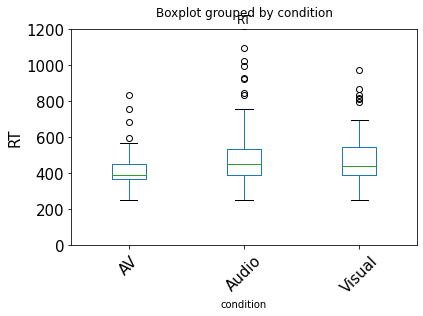

In [16]:
df_melt = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['Audio', 'Visual', 'AV'])
# replace column names
df_melt.columns = ['index', 'condition', 'RT']

# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('RT ~ C(condition)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table


fig = plt.figure(figsize=(6,4))
ax=df_melt.boxplot(column='RT', by='condition',grid=False, rot=45, fontsize=15)
#fig.set_ylabel('RT')
ax.set_ylabel('RT', fontsize=15)
ax.set_ylim((0,1200))
#df.boxplot(grid=False, rot=45, fontsize=15)
plt.show()

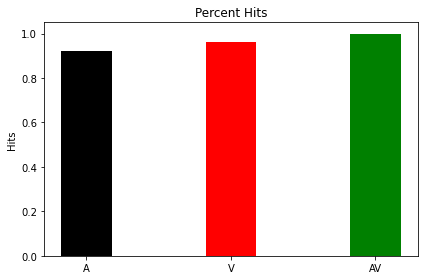

In [17]:
labels = ['A','V','AV']
means = [np.mean(ANSWER_AUDIO),np.mean(ANSWER_VIS),np.mean(ANSWER_AV)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x , means, width,color=['black', 'red', 'green'])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Hits')
ax.set_title('Percent Hits')
ax.set_xticks(x)
ax.set_xticklabels(labels)


fig.tight_layout()

plt.show()

## Reference
Fearon, C., Butler, J. S., Newman, L., Lynch, T., & Reilly, R. B. (2015). Audiovisual processing is abnormal in Parkinson’s disease and correlates with freezing of gait and disease duration. Journal of Parkinson's disease, 5(4), 925-936.

In [18]:
df_melt.head()

,index,condition,RT
0,0,Audio,415.0
1,1,Audio,406.2
2,2,Audio,687.8
3,3,Audio,458.0
4,4,Audio,429.9


In [19]:
import ddm.plot
from ddm import Model, Fittable
from ddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayChain,OverlayNonDecision,OverlayPoissonMixture,BoundCollapsingExponential
from ddm.functions import fit_adjust_model, display_model
from ddm import Sample

from ddm.plot import model_gui
from ddm.models import LossRobustBIC
from ddm.functions import fit_adjust_model, display_model



In [20]:
#Cor=np.concatenate((ANSWER_AUDIO, ANSWER_VIS,ANSWER_AV), axis=0)
#RT=np.concatenate((RT_AUDIO, RT_VIS,RT_AV), axis=0)
#RT=RT/1000
#cond=np.concatenate((np.repeat("A",RT_AUDIO.shape[0] ),np.repeat("AV",RT_AUDIO.shape[0] ),np.repeat("AV",RT_AUDIO.shape[0] )))
df_audio=pd.DataFrame({'RT': RT_AUDIO/1000, 'correct': ANSWER_AUDIO})
df_audio.head()

,RT,correct
0,0.4150,1.0
1,0.4062,1.0
2,0.6878,1.0
3,0.4580,1.0
4,0.4299,1.0


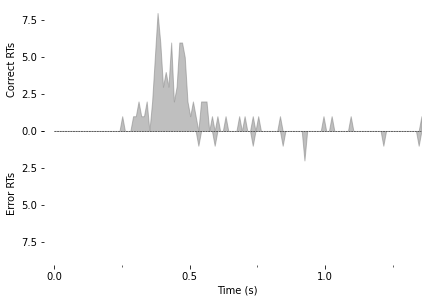

In [21]:
audio_sample = Sample.from_pandas_dataframe(df_audio, rt_column_name="RT",
                                              correct_column_name="correct")
ddm.plot.plot_fit_diagnostics( sample=audio_sample)

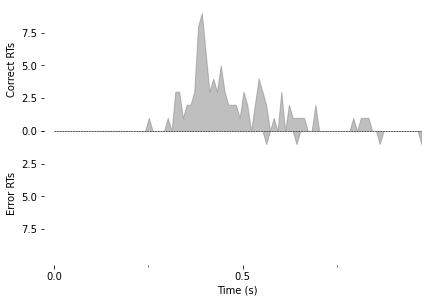

In [22]:
df_vis=pd.DataFrame({'RT': RT_VIS/1000, 'correct': ANSWER_VIS})
df_vis.head()
vis_sample = Sample.from_pandas_dataframe(df_vis, rt_column_name="RT",
                                              correct_column_name="correct")
ddm.plot.plot_fit_diagnostics( sample=vis_sample)


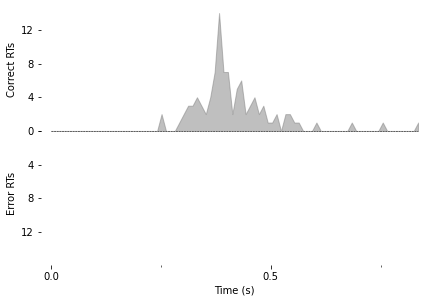

In [23]:
df_AV=pd.DataFrame({'RT': RT_AV/1000, 'correct': ANSWER_AV})
df_AV.head()
AV_sample = Sample.from_pandas_dataframe(df_AV, rt_column_name="RT",
                                              correct_column_name="correct")
ddm.plot.plot_fit_diagnostics( sample=AV_sample)



Params [9.26165647 3.84703177 2.44102644 0.26341077] gave -31.03065926087104


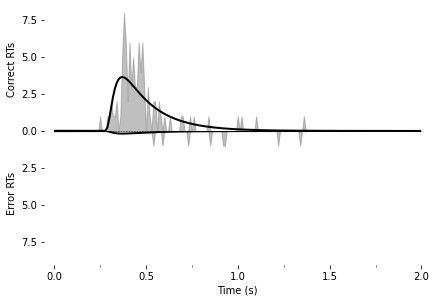

In [24]:
model_audio = Model(name='Audio',
                  drift=DriftConstant(drift=Fittable(minval=0, maxval=10)),
                  noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
                  bound=BoundConstant(B=Fittable(minval=.0, maxval=4)),
                  overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.8)),
                                                OverlayPoissonMixture(pmixturecoef=.02,
                                                                      rate=1)]),
                  dx=.001, dt=.01, T_dur=2)

# Fitting this will also be fast because PyDDM can automatically
# determine that DriftCoherence will allow an analytical solution.
fit_model_audio = fit_adjust_model(sample=audio_sample, model=model_audio,fitting_method="differential_evolution",
                 lossfunction=LossRobustBIC,verbose=False)
ddm.plot.plot_fit_diagnostics(model=fit_model_audio, sample=audio_sample)

Params [10.77594751  3.42250496  2.29489663  0.27533085] gave -98.4861869003366


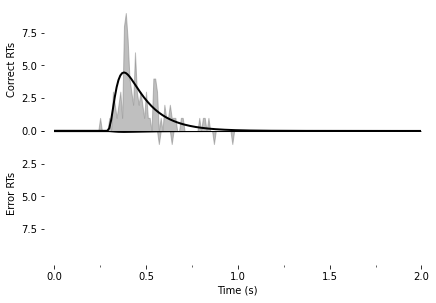

In [25]:
model_vis = Model(name='Visual',
                  drift=DriftConstant(drift=Fittable(minval=5, maxval=12)),
                  noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
                  bound=BoundConstant(B=Fittable(minval=.0, maxval=4)),
                  overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.8)),
                                                OverlayPoissonMixture(pmixturecoef=.02,
                                                                      rate=1)]),
                  dx=.001, dt=.01, T_dur=2)

# Fitting this will also be fast because PyDDM can automatically
# determine that DriftCoherence will allow an analytical solution.
fit_model_vis = fit_adjust_model(sample=vis_sample, model=model_vis,fitting_method="differential_evolution",
                 lossfunction=LossRobustBIC,verbose=False)
ddm.plot.plot_fit_diagnostics(model=fit_model_vis, sample=vis_sample)

Params [7.54365793 1.08896722 2.2781136  0.11984593] gave -201.97382205463546


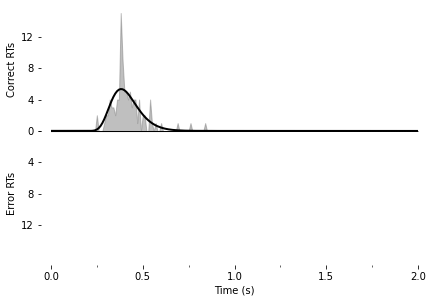

In [27]:
model_AV = Model(name='AV',
                  drift=DriftConstant(drift=Fittable(minval=0, maxval=10)),
                  noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
                  bound=BoundConstant(B=Fittable(minval=.0, maxval=4)),
                  overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.8)),
                                                OverlayPoissonMixture(pmixturecoef=.02,
                                                                      rate=1)]),
                  dx=.001, dt=.01, T_dur=2)

# Fitting this will also be fast because PyDDM can automatically
# determine that DriftCoherence will allow an analytical solution.
fit_model_AV = fit_adjust_model(sample=AV_sample, model=model_AV,fitting_method="differential_evolution",
                 lossfunction=LossRobustBIC,verbose=False)

ddm.plot.plot_fit_diagnostics(model=fit_model_AV, sample=AV_sample)

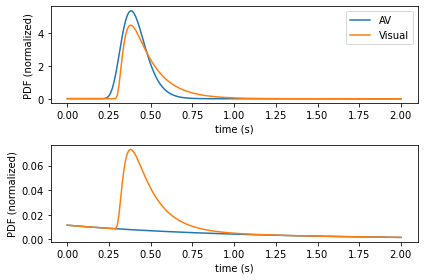

In [28]:
ddm.plot.plot_compare_solutions(fit_model_AV.solve(), fit_model_vis.solve())
plt.tight_layout()

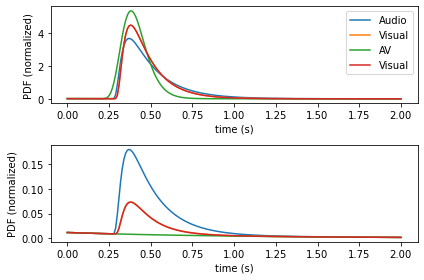

In [29]:
ddm.plot.plot_compare_solutions(fit_model_audio.solve(), fit_model_vis.solve())
plt.tight_layout()
ddm.plot.plot_compare_solutions(fit_model_AV.solve(), fit_model_vis.solve())
plt.tight_layout()

In [30]:
display_model(fit_model_AV)

Model AV information:
Drift component DriftConstant:
    constant
    Fitted parameters:
    - drift: 7.543658
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 1.088967
Bound component BoundConstant:
    constant
    Fitted parameters:
    - B: 2.278114
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.119846
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.020000
        - rate: 1.000000
Fit information:
    Loss function: BIC
    Loss function value: -201.97382205463546
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 100
        - mess: ''



In [31]:
display_model(fit_model_audio)

Model Audio information:
Drift component DriftConstant:
    constant
    Fitted parameters:
    - drift: 9.261656
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 3.847032
Bound component BoundConstant:
    constant
    Fitted parameters:
    - B: 2.441026
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.263411
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.020000
        - rate: 1.000000
Fit information:
    Loss function: BIC
    Loss function value: -31.03065926087104
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 100
        - mess: ''



In [32]:
display_model(fit_model_vis)

Model Visual information:
Drift component DriftConstant:
    constant
    Fitted parameters:
    - drift: 10.775948
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 3.422505
Bound component BoundConstant:
    constant
    Fitted parameters:
    - B: 2.294897
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.275331
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.020000
        - rate: 1.000000
Fit information:
    Loss function: BIC
    Loss function value: -98.4861869003366
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 100
        - mess: ''



https://pyddm.readthedocs.io/en/stable/cookbook/howto.html#howto-shared-params